# Deep Q-learning (DQL) or Deep Q-network (DQN)

In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
import numpy as np

In [2]:
import tensorflow as tf
print('TensorFlow Version: {}'.format(tf.__version__))
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

>**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [3]:
import gym

## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0') # 200 total reward as goal
env = gym.make('CartPole-v1') # 500 total reward as goal

/home/arasdar/anaconda3/lib/python3.6/site-packages/gym/envs/registration.py:14: PkgResourcesDeprecationWarning: Parameters to load are deprecated.  Call .resolve and .require separately.
  result = entry_point.load(False)


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [4]:
# env.reset()
# batch = []
# for _ in range(1000):
#     # env.render()
#     action = env.action_space.sample()
#     state, reward, done, info = env.step(action) # take a random action
#     batch.append([action, state, reward, done, info])
#     #print('state, action, reward, done, info:', state, action, reward, done, info)
#     if done:
#         env.reset()

To shut the window showing the simulation, use `env.close()`.

If you ran the simulation above, we can look at the rewards:

In [5]:
# batch[0], batch[0][1].shape

In [6]:
# actions = np.array([each[0] for each in batch])
# states = np.array([each[1] for each in batch])
# rewards = np.array([each[2] for each in batch])
# dones = np.array([each[3] for each in batch])
# infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
# print(np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
# print(np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
# print(np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
# print(np.max(np.array(rewards)), np.min(np.array(rewards)))
# print(np.max(np.array(states)), np.min(np.array(states)))

The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [53]:
def model_input(state_size, action_size):
    actions = tf.placeholder(tf.int32, [None], name='actions')
    actions_logits = tf.placeholder(tf.float32, [None, action_size], name='actions_logits')
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    next_states = tf.placeholder(tf.float32, [None, state_size], name='next_states')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    is_training = tf.placeholder(tf.bool, name='is_training')
    return actions, actions_logits, states, next_states, targetQs, is_training

In [54]:
def init_xavier(random_seed=1, dtype=tf.float32, uniform=False):
    xavier = tf.contrib.layers.xavier_initializer(
        dtype=dtype,
        seed=tf.set_random_seed(random_seed), 
        uniform=uniform) # False: normal
    return xavier

In [55]:
def mlp(inputs, units, trainable=True):
    outputs = tf.layers.dense(
        inputs=inputs,
        units=units,
        activation=None,
        use_bias=True,
        kernel_initializer=init_xavier(), # Xavier with normal init
        bias_initializer=tf.zeros_initializer(),
        kernel_regularizer=None,
        bias_regularizer=None,
        activity_regularizer=None,
        kernel_constraint=None,
        bias_constraint=None,
        trainable=trainable,
        name=None,
        reuse=None)
    return outputs

In [56]:
# tf.nn.leaky_relu(
#     features,
#     alpha=0.2,
#     name=None
# )
def nl(inputs, alpha=0.2):
    outputs = tf.maximum(alpha * inputs, inputs)
    return outputs

In [57]:
def bn(inputs, training=False):
    outputs = tf.layers.batch_normalization(
        inputs=inputs,
        axis=-1,
        momentum=0.99,
        epsilon=0.001,
        center=True,
        scale=True,
        beta_initializer=tf.zeros_initializer(),
        gamma_initializer=tf.ones_initializer(),
        moving_mean_initializer=tf.zeros_initializer(),
        moving_variance_initializer=tf.ones_initializer(),
        beta_regularizer=None,
        gamma_regularizer=None,
        beta_constraint=None,
        gamma_constraint=None,
        training=training,
        trainable=True,
        name=None,
        reuse=None,
        renorm=False,
        renorm_clipping=None,
        renorm_momentum=0.99,
        fused=None,
        virtual_batch_size=None,
        adjustment=None)
    return outputs

In [58]:
# Generator/Autorencoder/Adv
def G(states, actions_logits, state_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('G', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = tf.concat([h, actions_logits], axis=1)
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        next_states_ = mlp(inputs=h, units=state_size)
        return next_states_

In [59]:
# Actor-Critic/ D/Q
def D(states, action_size, hidden_size, reuse=False, alpha=0.2, is_training=False):
    with tf.variable_scope('D', reuse=reuse):
        # First fully connected layer
        h = mlp(inputs=states, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(states.shape, h.shape)
        
        # Second fully connected layer
        h = mlp(inputs=h, units=hidden_size)
        h = bn(inputs=h, training=is_training)
        h = nl(h)
        print(h.shape)
        
        # Output layer
        actions = mlp(inputs=h, units=action_size)
        return actions

In [67]:
def model_loss(actions, actions_logits, states, next_states, targetQs, state_size, action_size, hidden_size, 
               is_training=False):

    next_states_ = G(states=states, actions_logits=actions_logits, hidden_size=hidden_size, 
                     state_size=state_size, is_training=is_training)
    
    gloss = tf.reduce_mean(tf.reduce_sum((next_states - next_states_)**2, axis=1))

    actions_logits_ = D(states=states, hidden_size=hidden_size, action_size=action_size, 
                        is_training=is_training)
    
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits_.dtype)
    
    Qs = tf.reduce_max(actions_logits_ * actions_labels, axis=1)
    
    dloss = tf.reduce_mean((Qs - targetQs)**2)
    
    return actions_logits_, next_states_, gloss, dloss

In [68]:
def model_opt(gloss, dloss, learning_rate):
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('G')]
    d_vars = [var for var in t_vars if var.name.startswith('D')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(gloss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(dloss, var_list=d_vars)

    return g_opt, d_opt

In [69]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        (self.actions, self.actions_logits, self.states, self.next_states, self.targetQs, \
         self.is_training) = model_input(state_size=state_size, action_size=action_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits_, self.next_states_, self.gloss, self.dloss = model_loss(
            action_size=action_size, hidden_size=hidden_size, state_size=state_size,
            states=self.states, next_states=self.next_states, 
            actions=self.actions, actions_logits=self.actions_logits,
            targetQs=self.targetQs, is_training=self.is_training)

        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(gloss=self.gloss, dloss=self.dloss, learning_rate=learning_rate)

## Experience replay

Reinforcement learning algorithms can have stability issues due to correlations between states. To reduce correlations when training, we can store the agent's experiences and later draw a random mini-batch of those experiences to train on. 

Here, we'll create a `Memory` object that will store our experiences, our transitions $<s, a, r, s'>$. This memory will have a maxmium capacity, so we can keep newer experiences in memory while getting rid of older experiences. Then, we'll sample a random mini-batch of transitions $<s, a, r, s'>$ and train on those.

Below, I've implemented a `Memory` object. If you're unfamiliar with `deque`, this is a double-ended queue. You can think of it like a tube open on both sides. You can put objects in either side of the tube. But if it's full, adding anything more will push an object out the other side. This is a great data structure to use for the memory buffer.

In [70]:
from collections import deque
class Memory():
    def __init__(self, max_size = 1000):
        self.buffer = deque(maxlen=max_size)
    def sample(self, batch_size):
        idx = np.random.choice(np.arange(len(self.buffer)), 
                               size=batch_size, 
                               replace=False)
        return [self.buffer[ii] for ii in idx]

## Exploration - Exploitation

To learn about the environment and rules of the game, the agent needs to explore by taking random actions. We'll do this by choosing a random action with some probability $\epsilon$ (epsilon).  That is, with some probability $\epsilon$ the agent will make a random action and with probability $1 - \epsilon$, the agent will choose an action from $Q(s,a)$. This is called an **$\epsilon$-greedy policy**.


At first, the agent needs to do a lot of exploring. Later when it has learned more, the agent can favor choosing actions based on what it has learned. This is called _exploitation_. We'll set it up so the agent is more likely to explore early in training, then more likely to exploit later in training.

## Q-Learning training algorithm

Putting all this together, we can list out the algorithm we'll use to train the network. We'll train the network in _episodes_. One *episode* is one simulation of the game. For this game, the goal is to keep the pole upright for 195 frames. So we can start a new episode once meeting that goal. The game ends if the pole tilts over too far, or if the cart moves too far the left or right. When a game ends, we'll start a new episode. Now, to train the agent:

* Initialize the memory $D$
* Initialize the action-value network $Q$ with random weights
* **For** episode = 1, $M$ **do**
  * **For** $t$, $T$ **do**
     * With probability $\epsilon$ select a random action $a_t$, otherwise select $a_t = \mathrm{argmax}_a Q(s,a)$
     * Execute action $a_t$ in simulator and observe reward $r_{t+1}$ and new state $s_{t+1}$
     * Store transition $<s_t, a_t, r_{t+1}, s_{t+1}>$ in memory $D$
     * Sample random mini-batch from $D$: $<s_j, a_j, r_j, s'_j>$
     * Set $\hat{Q}_j = r_j$ if the episode ends at $j+1$, otherwise set $\hat{Q}_j = r_j + \gamma \max_{a'}{Q(s'_j, a')}$
     * Make a gradient descent step with loss $(\hat{Q}_j - Q(s_j, a_j))^2$
  * **endfor**
* **endfor**

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [71]:
# print('state size:{}'.format(states.shape), 
#       'actions:{}'.format(actions.shape)) 
# print('action size:', np.max(actions) - np.min(actions)+1)

In [72]:
# Exploration parameters
explore_start = 1.0            # exploration probability at start
explore_stop = 0.01            # minimum exploration probability 
decay_rate = 0.0001            # exponential decay rate for exploration prob

# Network parameters
action_size = 2
state_size = 4
hidden_size = 64               # number of units in each Q-network hidden layer
learning_rate = 1e-04         # Q-network learning rate

# Memory parameters
memory_size = int(1e5)            # memory capacity
batch_size = 20             # experience mini-batch size
gamma = 0.99                 # future reward discount

In [73]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

# Init the memory
memory = Memory(max_size=memory_size)

(?, 4) (?, 64)
(?, 64)
(?, 4) (?, 64)
(?, 64)


## Populate the memory (exprience memory)

Here I'm re-initializing the simulation and pre-populating the memory. The agent is taking random actions and storing the transitions in memory. This will help the agent with exploring the game.

In [74]:
# state = env.reset()

# for _ in range(memory_size):
    
#     action = env.action_space.sample()
    
#     next_state, reward, done, _ = env.step(action)
    
#     memory.buffer.append([state, action, next_state, reward, float(done)])
    
#     state = next_state
    
#     if done is True:
#         state = env.reset()

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [77]:
def learn(sess, memory, batch_size):
    
    batch = memory.sample(batch_size)
    states = np.array([each[0] for each in batch])
    actions = np.array([each[1] for each in batch])
    next_states = np.array([each[2] for each in batch])
    rewards = np.array([each[3] for each in batch])
    dones = np.array([each[4] for each in batch])
    actions_logits = np.array([each[5] for each in batch])
    
    next_actions_logits_ = sess.run(model.actions_logits_, feed_dict = {model.states: next_states, 
                                                                        model.is_training: False})
    
    nextQs = np.max(next_actions_logits_, axis=1) * (1-dones)
    
    targetQs = rewards + (gamma * nextQs)
    
    feed_dict = {model.states: states, model.actions: actions, model.actions_logits: actions_logits,
                 model.next_states: next_states, model.targetQs: targetQs, model.is_training: False}
    
    dloss, _ = sess.run([model.dloss, model.d_opt], feed_dict)
    gloss, _ = sess.run([model.gloss, model.g_opt], feed_dict)
                                                             
    return gloss, dloss

In [78]:
def env_(sess, state, action_logits):
    
    next_state_ = sess.run(model.next_states_, feed_dict={
        model.states: state.reshape([1, -1]), 
        model.actions_logits: action_logits.reshape([1, -1]),
        model.is_training: False})
    
    return next_state_

In [79]:
def act(sess, state):
    
    action_logits_ = sess.run(model.actions_logits_, feed_dict={model.states: state.reshape([1, -1]), 
                                                                model.is_training: False})
    
    action = np.argmax(action_logits, axis=1)[0]
    #print(action)
    
    return action, action_logits_

In [25]:
# Save/load the model and save for plotting
saver = tf.train.Saver()
episode_rewards_list, rewards_list, loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    total_step = 0 # Explore or exploit parameter
    episode_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window
    
    # Training episodes/epochs
    for ep in range(11111):
        total_reward = 0
        loss_batch = []
        state = env.reset()

        # Training steps/batches
        while True:
            # Explore (Env) or Exploit (Model)
            total_step += 1
            explore_p = explore_stop + (explore_start - explore_stop) * np.exp(-decay_rate * total_step)
            
            if explore_p > np.random.rand():
                action = env.action_space.sample()
            else:
                action = act(sess, state)
                
            next_state, reward, done, _ = env.step(action)
            
            memory.buffer.append([state, action, next_state, reward, float(done)])
            
            total_reward += reward
            state = next_state

            # Training
            loss = learn(sess, memory, batch_size)
            loss_batch.append(loss)
            
            if done is True:
                break
                
        episode_reward.append(total_reward)
        
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episode_reward)),
              'R:{}'.format(total_reward),
              'loss:{:.4f}'.format(np.mean(loss_batch)),
              'exploreP:{:.4f}'.format(explore_p))
        
        # Ploting out
        episode_rewards_list.append([ep, np.mean(episode_reward)])
        rewards_list.append([ep, total_reward])
        loss_list.append([ep, np.mean(loss_batch)])
        
        # Break episode/epoch loop
        if np.mean(episode_reward) >= 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode:0 meanR:11.0000 R:11.0 loss:1.0649 exploreP:0.9989
Episode:1 meanR:11.5000 R:12.0 loss:1.0596 exploreP:0.9977
Episode:2 meanR:13.3333 R:17.0 loss:1.0589 exploreP:0.9960
Episode:3 meanR:15.5000 R:22.0 loss:1.0487 exploreP:0.9939
Episode:4 meanR:14.8000 R:12.0 loss:1.0408 exploreP:0.9927
Episode:5 meanR:15.1667 R:17.0 loss:1.0543 exploreP:0.9910
Episode:6 meanR:15.5714 R:18.0 loss:1.0506 exploreP:0.9893
Episode:7 meanR:15.1250 R:12.0 loss:1.0514 exploreP:0.9881
Episode:8 meanR:15.0000 R:14.0 loss:1.0392 exploreP:0.9867
Episode:9 meanR:14.4000 R:9.0 loss:1.0770 exploreP:0.9858
Episode:10 meanR:14.1818 R:12.0 loss:1.1022 exploreP:0.9847
Episode:11 meanR:14.3333 R:16.0 loss:1.1119 exploreP:0.9831
Episode:12 meanR:14.3077 R:14.0 loss:1.1076 exploreP:0.9818
Episode:13 meanR:14.6429 R:19.0 loss:1.1412 exploreP:0.9799
Episode:14 meanR:16.0667 R:36.0 loss:1.1942 exploreP:0.9764
Episode:15 meanR:15.8750 R:13.0 loss:1.2053 exploreP:0.9752
Episode:16 meanR:16.1765 R:21.0 loss:1.2868 explore

Episode:135 meanR:19.6100 R:31.0 loss:54.2154 exploreP:0.7688
Episode:136 meanR:19.5700 R:33.0 loss:58.2897 exploreP:0.7663
Episode:137 meanR:19.3600 R:11.0 loss:79.2183 exploreP:0.7654
Episode:138 meanR:19.3100 R:26.0 loss:64.4700 exploreP:0.7635
Episode:139 meanR:19.2400 R:24.0 loss:42.3941 exploreP:0.7617
Episode:140 meanR:19.2200 R:14.0 loss:48.6962 exploreP:0.7606
Episode:141 meanR:19.1600 R:25.0 loss:42.8818 exploreP:0.7587
Episode:142 meanR:19.0600 R:9.0 loss:90.3591 exploreP:0.7581
Episode:143 meanR:18.9800 R:27.0 loss:62.5712 exploreP:0.7561
Episode:144 meanR:18.9500 R:16.0 loss:46.5843 exploreP:0.7549
Episode:145 meanR:18.8500 R:16.0 loss:43.0136 exploreP:0.7537
Episode:146 meanR:18.7800 R:10.0 loss:101.2145 exploreP:0.7529
Episode:147 meanR:18.5800 R:12.0 loss:56.4109 exploreP:0.7520
Episode:148 meanR:18.4500 R:14.0 loss:73.6595 exploreP:0.7510
Episode:149 meanR:18.2600 R:14.0 loss:40.0985 exploreP:0.7500
Episode:150 meanR:18.4600 R:32.0 loss:49.9503 exploreP:0.7476
Episode:

Episode:268 meanR:21.8400 R:28.0 loss:22.4393 exploreP:0.5816
Episode:269 meanR:22.3000 R:62.0 loss:20.2994 exploreP:0.5780
Episode:270 meanR:22.5100 R:35.0 loss:19.1051 exploreP:0.5761
Episode:271 meanR:22.9500 R:61.0 loss:19.3359 exploreP:0.5726
Episode:272 meanR:23.1100 R:35.0 loss:15.3428 exploreP:0.5707
Episode:273 meanR:23.1700 R:31.0 loss:15.6391 exploreP:0.5689
Episode:274 meanR:24.0700 R:102.0 loss:18.3583 exploreP:0.5632
Episode:275 meanR:24.0700 R:19.0 loss:22.0913 exploreP:0.5622
Episode:276 meanR:24.1100 R:15.0 loss:15.4033 exploreP:0.5614
Episode:277 meanR:24.2200 R:24.0 loss:19.2073 exploreP:0.5600
Episode:278 meanR:24.2300 R:21.0 loss:13.3593 exploreP:0.5589
Episode:279 meanR:24.2700 R:35.0 loss:20.7492 exploreP:0.5570
Episode:280 meanR:24.2700 R:18.0 loss:22.4928 exploreP:0.5560
Episode:281 meanR:24.4200 R:31.0 loss:20.6719 exploreP:0.5543
Episode:282 meanR:24.7200 R:44.0 loss:16.3095 exploreP:0.5519
Episode:283 meanR:25.6300 R:101.0 loss:19.6811 exploreP:0.5465
Episod

Episode:400 meanR:71.8500 R:79.0 loss:43.2693 exploreP:0.2517
Episode:401 meanR:72.8000 R:130.0 loss:42.1680 exploreP:0.2486
Episode:402 meanR:72.7700 R:80.0 loss:43.6749 exploreP:0.2467
Episode:403 meanR:73.0900 R:83.0 loss:39.9397 exploreP:0.2447
Episode:404 meanR:73.1100 R:62.0 loss:54.2470 exploreP:0.2432
Episode:405 meanR:73.5600 R:83.0 loss:47.9117 exploreP:0.2413
Episode:406 meanR:73.6500 R:62.0 loss:36.6226 exploreP:0.2399
Episode:407 meanR:73.8900 R:56.0 loss:45.2109 exploreP:0.2386
Episode:408 meanR:73.4400 R:61.0 loss:50.0337 exploreP:0.2372
Episode:409 meanR:73.8900 R:75.0 loss:47.2851 exploreP:0.2355
Episode:410 meanR:74.0100 R:81.0 loss:48.2554 exploreP:0.2337
Episode:411 meanR:74.4800 R:77.0 loss:61.9773 exploreP:0.2320
Episode:412 meanR:74.8700 R:81.0 loss:51.7099 exploreP:0.2302
Episode:413 meanR:75.5100 R:95.0 loss:45.1874 exploreP:0.2281
Episode:414 meanR:75.8300 R:83.0 loss:62.1963 exploreP:0.2263
Episode:415 meanR:76.1800 R:95.0 loss:48.4926 exploreP:0.2243
Episode

Episode:530 meanR:181.7600 R:361.0 loss:149.2420 exploreP:0.0387
Episode:531 meanR:182.6400 R:213.0 loss:123.2655 exploreP:0.0381
Episode:532 meanR:183.2400 R:172.0 loss:142.1382 exploreP:0.0376
Episode:533 meanR:183.9800 R:153.0 loss:124.0429 exploreP:0.0372
Episode:534 meanR:185.8100 R:257.0 loss:143.9708 exploreP:0.0365
Episode:535 meanR:187.5900 R:256.0 loss:145.9490 exploreP:0.0359
Episode:536 meanR:188.1200 R:154.0 loss:170.5119 exploreP:0.0355
Episode:537 meanR:188.8900 R:163.0 loss:132.9930 exploreP:0.0351
Episode:538 meanR:191.0000 R:274.0 loss:139.6208 exploreP:0.0344
Episode:539 meanR:191.2700 R:145.0 loss:125.7484 exploreP:0.0340
Episode:540 meanR:192.0200 R:168.0 loss:125.0363 exploreP:0.0336
Episode:541 meanR:194.0700 R:307.0 loss:126.6466 exploreP:0.0329
Episode:542 meanR:195.9400 R:405.0 loss:132.2972 exploreP:0.0320
Episode:543 meanR:197.4000 R:236.0 loss:136.0668 exploreP:0.0315
Episode:544 meanR:199.1900 R:278.0 loss:162.7456 exploreP:0.0309
Episode:545 meanR:200.880

Episode:656 meanR:322.1700 R:274.0 loss:9263.8799 exploreP:0.0106
Episode:657 meanR:322.4400 R:243.0 loss:9534.9775 exploreP:0.0106
Episode:658 meanR:320.8400 R:227.0 loss:9807.4912 exploreP:0.0106
Episode:659 meanR:320.9400 R:257.0 loss:9912.3418 exploreP:0.0105
Episode:660 meanR:323.1000 R:441.0 loss:10307.3662 exploreP:0.0105
Episode:661 meanR:322.7300 R:248.0 loss:9519.1367 exploreP:0.0105
Episode:662 meanR:324.0000 R:318.0 loss:13437.5332 exploreP:0.0105
Episode:663 meanR:324.6600 R:241.0 loss:14174.9170 exploreP:0.0105
Episode:664 meanR:324.2700 R:273.0 loss:12460.9189 exploreP:0.0105
Episode:665 meanR:321.4400 R:217.0 loss:16106.3799 exploreP:0.0105
Episode:666 meanR:321.4600 R:422.0 loss:13361.4434 exploreP:0.0104
Episode:667 meanR:321.0100 R:315.0 loss:13790.4648 exploreP:0.0104
Episode:668 meanR:321.1400 R:269.0 loss:14632.0244 exploreP:0.0104
Episode:669 meanR:321.9300 R:360.0 loss:17775.9629 exploreP:0.0104
Episode:670 meanR:320.6200 R:219.0 loss:16943.6445 exploreP:0.0104


Episode:778 meanR:197.1000 R:178.0 loss:155003.1719 exploreP:0.0100
Episode:779 meanR:194.2400 R:120.0 loss:154467.8594 exploreP:0.0100
Episode:780 meanR:193.0100 R:125.0 loss:150595.2188 exploreP:0.0100
Episode:781 meanR:191.4200 R:122.0 loss:146443.7188 exploreP:0.0100
Episode:782 meanR:191.3400 R:262.0 loss:162060.2500 exploreP:0.0100
Episode:783 meanR:190.7300 R:139.0 loss:162319.5938 exploreP:0.0100
Episode:784 meanR:189.5400 R:108.0 loss:160864.6875 exploreP:0.0100
Episode:785 meanR:189.7000 R:236.0 loss:162184.5938 exploreP:0.0100
Episode:786 meanR:189.3600 R:200.0 loss:161422.8438 exploreP:0.0100
Episode:787 meanR:188.3800 R:148.0 loss:170795.1250 exploreP:0.0100
Episode:788 meanR:188.4000 R:242.0 loss:171520.9531 exploreP:0.0100
Episode:789 meanR:187.9200 R:192.0 loss:162696.2969 exploreP:0.0100
Episode:790 meanR:187.3600 R:148.0 loss:162168.9844 exploreP:0.0100
Episode:791 meanR:185.6500 R:105.0 loss:168681.4531 exploreP:0.0100
Episode:792 meanR:184.4000 R:152.0 loss:176336.7

Episode:901 meanR:216.3000 R:9.0 loss:33618.2305 exploreP:0.0100
Episode:902 meanR:214.0400 R:10.0 loss:21092.6797 exploreP:0.0100
Episode:903 meanR:211.4400 R:10.0 loss:39318.6797 exploreP:0.0100
Episode:904 meanR:208.0800 R:9.0 loss:44652.5781 exploreP:0.0100
Episode:905 meanR:206.1800 R:9.0 loss:38871.2539 exploreP:0.0100
Episode:906 meanR:204.3300 R:8.0 loss:34054.5156 exploreP:0.0100
Episode:907 meanR:202.4800 R:9.0 loss:28494.7891 exploreP:0.0100
Episode:908 meanR:200.0600 R:9.0 loss:22362.6836 exploreP:0.0100
Episode:909 meanR:195.1500 R:9.0 loss:60860.3906 exploreP:0.0100
Episode:910 meanR:192.7900 R:8.0 loss:75450.7344 exploreP:0.0100
Episode:911 meanR:187.8800 R:9.0 loss:8355.0674 exploreP:0.0100
Episode:912 meanR:186.3500 R:9.0 loss:16111.3555 exploreP:0.0100
Episode:913 meanR:183.1700 R:10.0 loss:41008.5117 exploreP:0.0100
Episode:914 meanR:180.3900 R:9.0 loss:11369.1826 exploreP:0.0100
Episode:915 meanR:175.5700 R:9.0 loss:51222.1016 exploreP:0.0100
Episode:916 meanR:170.8

Episode:1028 meanR:11.2000 R:73.0 loss:67400.4219 exploreP:0.0100
Episode:1029 meanR:11.9500 R:83.0 loss:88445.4531 exploreP:0.0100
Episode:1030 meanR:12.6100 R:74.0 loss:100337.3750 exploreP:0.0100
Episode:1031 meanR:13.4100 R:90.0 loss:81503.7734 exploreP:0.0100
Episode:1032 meanR:14.0600 R:73.0 loss:98797.5859 exploreP:0.0100
Episode:1033 meanR:14.5500 R:58.0 loss:106560.8672 exploreP:0.0100
Episode:1034 meanR:15.1500 R:70.0 loss:115388.1562 exploreP:0.0100
Episode:1035 meanR:15.6700 R:62.0 loss:125432.5938 exploreP:0.0100
Episode:1036 meanR:16.1900 R:62.0 loss:116251.8672 exploreP:0.0100
Episode:1037 meanR:16.8600 R:76.0 loss:95572.0234 exploreP:0.0100
Episode:1038 meanR:17.6400 R:88.0 loss:128265.2578 exploreP:0.0100
Episode:1039 meanR:18.4600 R:92.0 loss:118667.2188 exploreP:0.0100
Episode:1040 meanR:19.1800 R:81.0 loss:106030.4219 exploreP:0.0100
Episode:1041 meanR:20.2500 R:117.0 loss:166576.5000 exploreP:0.0100
Episode:1042 meanR:21.1000 R:95.0 loss:132365.2500 exploreP:0.0100

Episode:1151 meanR:72.4500 R:168.0 loss:435307.4688 exploreP:0.0100
Episode:1152 meanR:72.4500 R:500.0 loss:450789.7500 exploreP:0.0100
Episode:1153 meanR:68.9400 R:149.0 loss:476474.1875 exploreP:0.0100
Episode:1154 meanR:66.0400 R:210.0 loss:448612.1875 exploreP:0.0100
Episode:1155 meanR:64.6800 R:181.0 loss:508621.6250 exploreP:0.0100
Episode:1156 meanR:65.0500 R:151.0 loss:419005.4062 exploreP:0.0100
Episode:1157 meanR:66.5900 R:230.0 loss:444652.9375 exploreP:0.0100
Episode:1158 meanR:67.9100 R:183.0 loss:502794.8438 exploreP:0.0100
Episode:1159 meanR:70.0900 R:228.0 loss:424780.8438 exploreP:0.0100
Episode:1160 meanR:72.3600 R:238.0 loss:543674.1250 exploreP:0.0100
Episode:1161 meanR:77.2700 R:500.0 loss:527200.8750 exploreP:0.0100
Episode:1162 meanR:82.1900 R:500.0 loss:525382.9375 exploreP:0.0100
Episode:1163 meanR:87.1000 R:500.0 loss:548545.9375 exploreP:0.0100
Episode:1164 meanR:92.0100 R:500.0 loss:537164.2500 exploreP:0.0100
Episode:1165 meanR:96.9300 R:500.0 loss:568022.6

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0, 0.5, 'Total rewards')

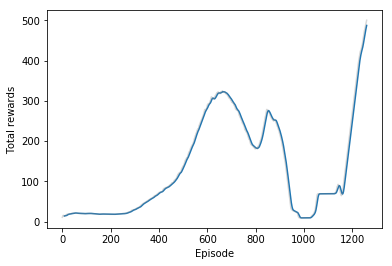

In [28]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

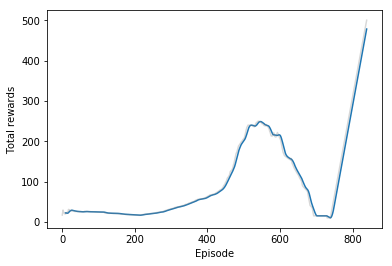

In [31]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

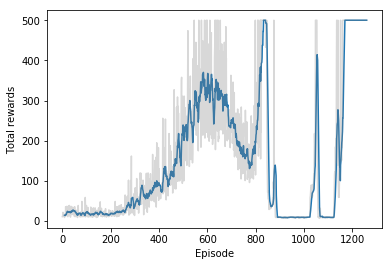

In [29]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

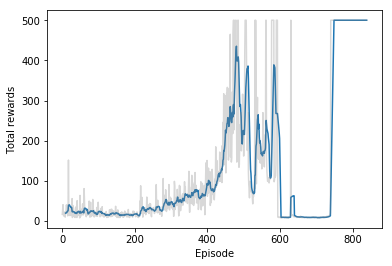

In [32]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

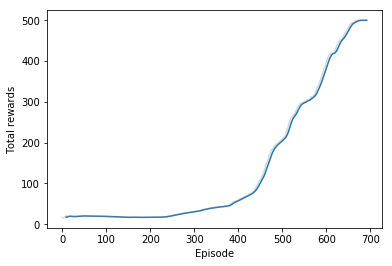

In [20]:
eps, arr = np.array(episode_rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0, 0.5, 'Total rewards')

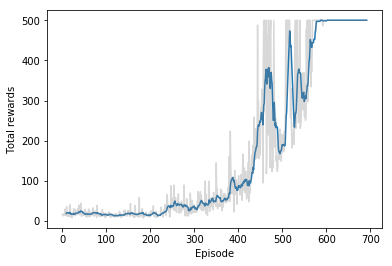

In [21]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

## Testing

Let's checkout how our trained agent plays the game.

In [36]:
# Creating a gym env
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')

# A training graph session
with tf.Session(graph=graph) as sess:
    #sess.run(tf.global_variables_initializer())
    saver.restore(sess, 'checkpoints/model-qn.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(10):
        state = env.reset()
        total_reward = 0

        # Steps/batches
        while True:
            env.render()
            
            action = act(sess, state)
            
            state, reward, done, _ = env.step(action)
            
            total_reward += reward
            
            if done:
                break
                
        # Closing the env
        print('total_reward: {}'.format(total_reward))

# Close the env at the end
env.close()

INFO:tensorflow:Restoring parameters from checkpoints/model-qn.ckpt
total_reward: 10.0
total_reward: 10.0
total_reward: 9.0
total_reward: 9.0
total_reward: 9.0
total_reward: 9.0
total_reward: 9.0
total_reward: 10.0
total_reward: 9.0
total_reward: 10.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.